In [1]:
import os
import numpy as np
import pandas as pd

import json
import pickle

# import cfdna_covid19

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':400, 'axes.linewidth':1,
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size} # 'figure.figsize':(11.7/1.5,8.27/1.5)

flatui_2cls = ['#e41a1c','#4daf4a']
flatui_3risk= ['#377eb8', '#984ea3','#ff7f00']

flatui = ['#ff7f00','#4daf4a','#984ea3','#377eb8', '#e41a1c']

sns.set(style='ticks',rc=rc) #talk, ticks, paper
sns.set_context("paper")
sns.color_palette(flatui_3risk)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign


In [3]:
import sklearn
print('sklearn:'+sklearn.__version__)

from sklearn import metrics
from scipy import stats

sklearn:0.23.2


In [4]:
model_re_root_dir = r'~/model'

raw_data_dir = r'~/data'

clinical_fname = r'~/399_clincal_fill.csv'

feat_types = 'lab, fragl, tss, motif, m2model'

map_name= {'lab': 'LABModel', 'fragl': 'FRAGLModel', 'tss': 'TSSModel', 'motif': 'MOTIFModel', 'm2model': 'M2Model'}

In [5]:
# load tss-gene name
tss_gene_ls_fname = r'~/20211104_model_feature/tss_177_trans_and_169gene.list'
tss_gene_df = pd.read_csv(tss_gene_ls_fname,sep='\t',names=['tss','gene','trans'], header=None)

In [6]:
max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}
def load_feat_importance_shap(i_feat_type, return_all=False):
    feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,i_feat_type+'/33_fl_feature_importance_shap.csv'), sep='\t')
    if return_all:
        return feat_imp_df
    else:
        return feat_imp_df.iloc[:max_feat_idx_ap[i_feat_type]+1,:]

def load_all_feats_name():
    lab_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'lab/33_fl_feature_importance_shap.csv'), sep='\t')
    fragl_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'fragl/33_fl_feature_importance_shap.csv'), sep='\t')
    tss_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'tss/33_fl_feature_importance_shap.csv'), sep='\t')
    motif_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'motif/33_fl_feature_importance_shap.csv'), sep='\t')
    
    feat_names = {}
    feat_names['lab']=lab_feat_imp_df['feat_name'].values
    feat_names['fragl']=fragl_feat_imp_df['feat_name'].values
    feat_names['tss']=tss_feat_imp_df['feat_name'].values
    feat_names['motif']=motif_feat_imp_df['feat_name'].values
    
    return feat_names

In [7]:
mean_preds = pd.read_csv('results_plt/100iters_tst_mean_preds_399pat_allmethods.csv',sep='\t')
mean_preds['labels']= mean_preds['new_triage'].apply(lambda x: 'Noncritical' if x ==0 else 'Critical')
mean_preds['PID']= ['PU{}'.format(x[5:9]) for x in mean_preds['ind'].values]

m2model_preds = mean_preds['ind,new_triage,mean_tst_pred_m2model,labels,PID'.split(',')].copy()
m2model_preds.sort_values(by=['new_triage','mean_tst_pred_m2model'],ascending = True, inplace=True)
m2model_preds['risk_level']=['Low Risk']*m2model_preds.shape[0]

i_fpr, i_tpr, i_thre = metrics.roc_curve(m2model_preds['new_triage'], m2model_preds['mean_tst_pred_m2model'])
# 98%
high_risk_thre = np.round_(i_thre[np.min(np.where(np.round_(i_fpr,2)==0.02))],2)
low_risk_thre = np.round_(i_thre[np.max(np.where(np.round_(i_tpr,2)==0.98))],2)

# 95%
# high_risk_thre = np.round_(i_thre[np.min(np.where(np.round_(i_fpr,2)==0.05))],2)
# low_risk_thre = np.round_(i_thre[np.max(np.where(np.round_(i_tpr,2)==0.94))+1],2)

print('98% Specificity, High Risk threshold: {:.2f}'.format(high_risk_thre))
print('98% Sensitivity, Low Risk threshold: {:.2f}'.format(low_risk_thre))

m2model_preds.loc[m2model_preds['mean_tst_pred_m2model']>high_risk_thre,'risk_level']='High Risk'
m2model_preds.loc[(m2model_preds['mean_tst_pred_m2model']>=low_risk_thre) & (m2model_preds['mean_tst_pred_m2model']<=high_risk_thre),
                  'risk_level']='Medium Risk'


98% Specificity, High Risk threshold: 0.35
98% Sensitivity, Low Risk threshold: 0.01


In [8]:
fp_highrisk_pats = m2model_preds[(m2model_preds['new_triage']==0) & (m2model_preds['risk_level']=='High Risk')]

In [ ]:
print(fp_highrisk_pats['PID'].values.tolist())
fp_highrisk_pats

In [10]:
n_h_risk = m2model_preds[m2model_preds['risk_level']=='High Risk'].shape[0]
n_h_risk_pos = m2model_preds[(m2model_preds['risk_level']=='High Risk') & 
                             (m2model_preds['new_triage']==1)].shape[0]

n_m_risk = m2model_preds[m2model_preds['risk_level']=='Medium Risk'].shape[0]
n_m_risk_pos = m2model_preds[(m2model_preds['risk_level']=='Medium Risk') & 
                             (m2model_preds['new_triage']==1)].shape[0]

n_l_risk = m2model_preds[m2model_preds['risk_level']=='Low Risk'].shape[0]
n_l_risk_pos = m2model_preds[(m2model_preds['risk_level']=='Low Risk') & 
                             (m2model_preds['new_triage']==1)].shape[0]

print(n_h_risk,n_h_risk_pos,
      n_m_risk,n_m_risk_pos,
      n_l_risk,n_l_risk_pos)

45 38 157 16 197 0


# Risk Stratification by M2Model (Focal loss)

## Risk Plot

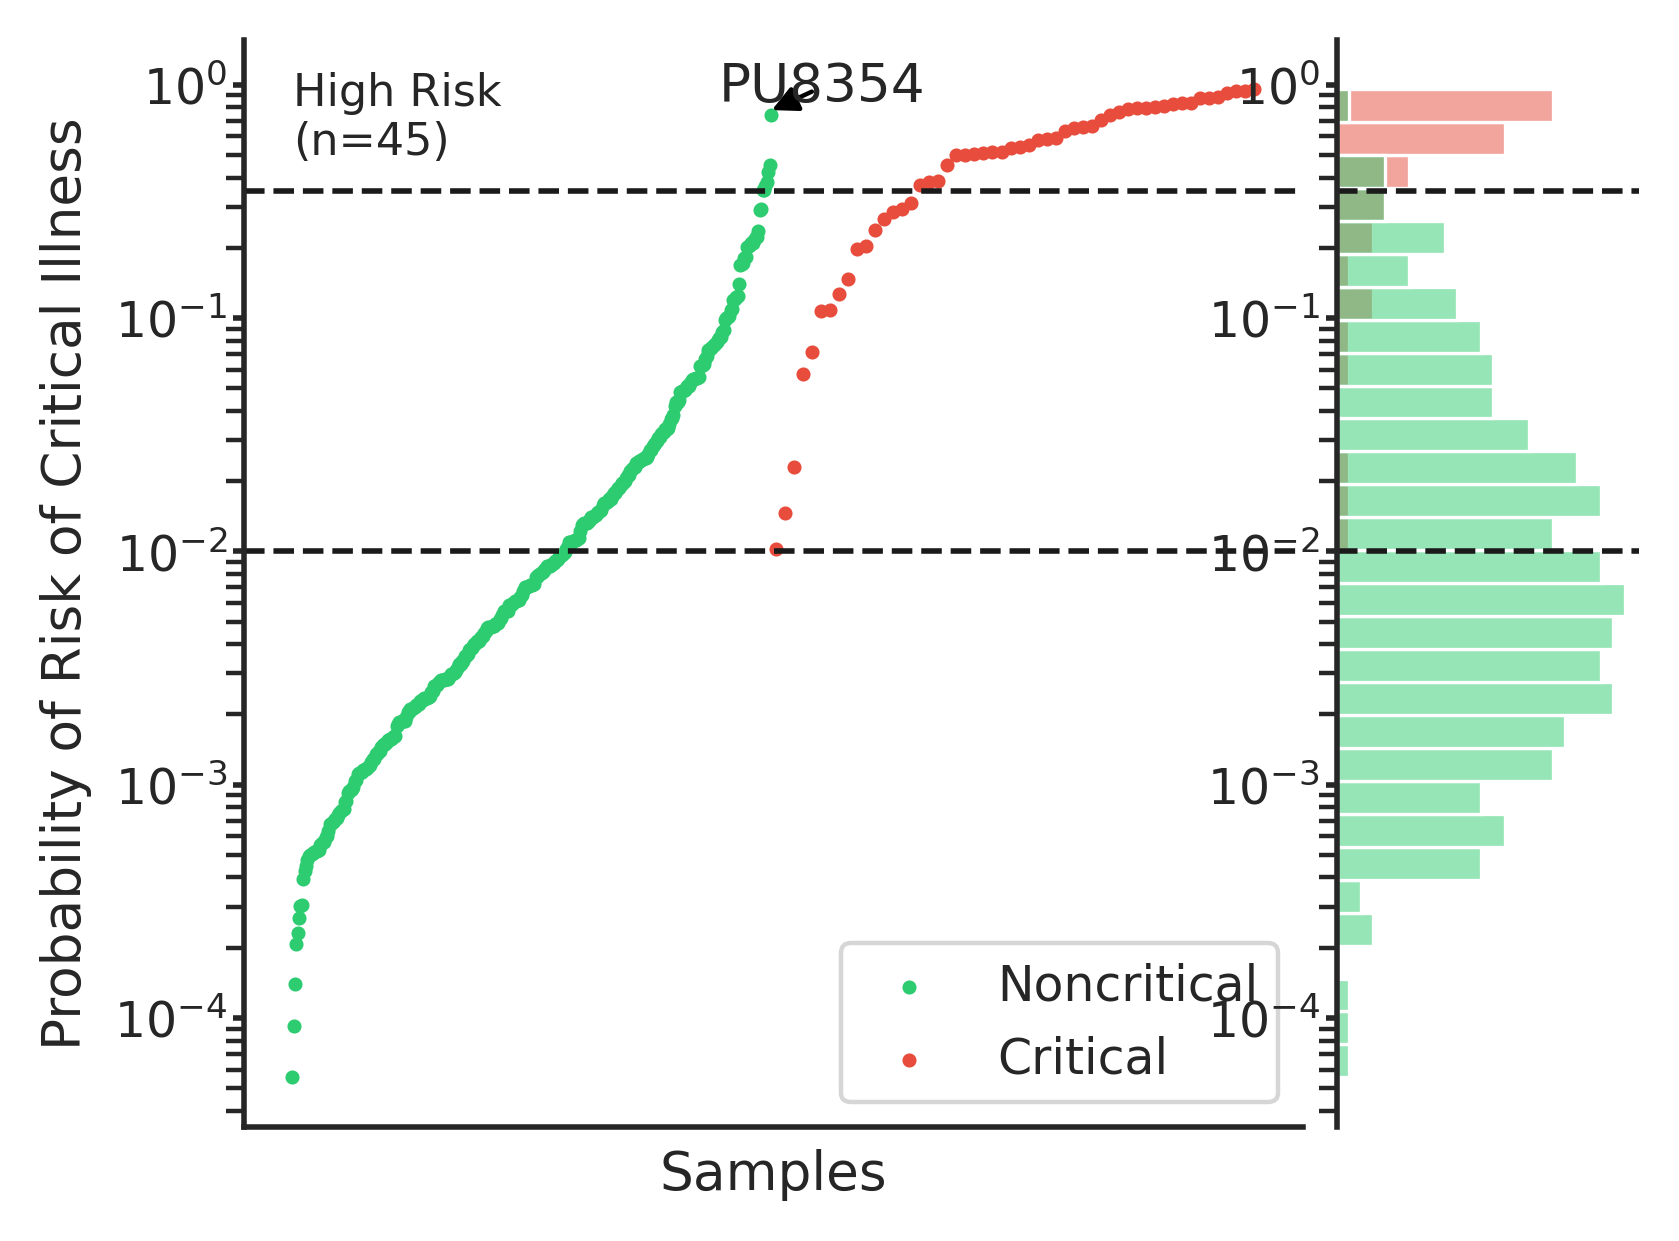

In [19]:
from matplotlib.gridspec import GridSpec

orders = ['Noncritical','Critical']
palette = dict(zip(orders, ['#2ecc71','#e74c3c']))

fig = plt.figure(figsize=(4.5,3.6))
gs1 = GridSpec(1, 2, wspace=0.05,width_ratios=[3.5, 1])
ax = fig.add_subplot(gs1[0])
ax1 = fig.add_subplot(gs1[1],sharey=ax)

x1 = np.linspace(0, 100, num=345)
x2 = np.linspace(101, 201, num=54)

s1 = ax.scatter(x1,
                 m2model_preds.loc[m2model_preds['new_triage']==0,'mean_tst_pred_m2model'],
                 c="#2ecc71",s=3)
s2 = ax.scatter(x2,
                 m2model_preds.loc[m2model_preds['new_triage']==1,'mean_tst_pred_m2model'], 
                 c="#e74c3c",s=3)

ax.text(0.1,high_risk_thre+0.15,'High Risk\n(n={})'.format(n_h_risk), fontsize=8)
ax.axhline(y=high_risk_thre, ls='--', lw=1,c='k')
# ax.text(0.1,high_risk_thre-0.15,'Medium Risk', fontsize=8) #bbox=dict(facecolor='#ff7f00', alpha=0.2, edgecolor='#ff7f00',boxstyle="round"))
ax.axhline(y=low_risk_thre, ls='--', lw=1,c='k')
# ax.text(0.1,low_risk_thre-0.012,'Low Risk', fontsize=8)

pid='8354'

fp_pat = fp_highrisk_pats[fp_highrisk_pats['ind'].str.slice(start=5,stop=9)==pid]
ax.annotate("PU{}".format(pid), 
                 xy=(x1[fp_pat.index]+10,fp_pat['mean_tst_pred_m2model']),
                 xytext=(x1[fp_pat.index]+1,fp_pat['mean_tst_pred_m2model']+0.1),
                 arrowprops=dict(arrowstyle="-|>",color='black'))

ax.set_yscale('log')
ax.set_xlabel('Samples')
ax.set_ylabel('Probability of Risk of Critical Illness')
ax.set_xticks([])
ax.legend((s1,s2),('Noncritical','Critical') ,loc = 'lower right')


sns.histplot(
    m2model_preds, y="mean_tst_pred_m2model", 
    hue="labels", 
    # kde=True, 
    ax=ax1, 
    bins=30,palette=palette, 
    line_kws=dict(linewidth=1)
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axhline(y=high_risk_thre, ls='--', lw=1,c='k')
ax1.axhline(y=low_risk_thre, ls='--', lw=1,c='k')

ax1.set_xticks([])
# ax1.set_yticks([])
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.get_legend().remove()

ax.tick_params(direction='out', length=2, pad=1)
ax1.tick_params(direction='out', length=2, pad=1)

plt.savefig("results_plt/risk_stratification.pdf", dpi=400, bbox_inches='tight', format='pdf')



In [ ]:
fp_pat

## Spearman correlation (features vs risk level)

In [23]:
m2model_feats = load_feat_importance_shap('m2model')['feat_name'].values
featnames = load_all_feats_name()
f_type=[]
for f in m2model_feats:
    for iiidx, t in enumerate('lab,fragl,tss,motif'.split(',')):
        if f in featnames[t]:
            f_type.append(t)
            break

f_type = np.array(f_type)

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [24]:
labs_names = m2model_feats[f_type=='lab']
lab_units = dict(zip(['LDH', 'Uric_acid', 'α-HBDH', 'PA'],['U/L','μmol/L','U/L','mg/L']))
print(labs_names)

# load raw lab data
lab_raw_dat = pd.read_csv(os.path.join(raw_data_dir, '399_labtest_fill.csv'))
lab_feat_data = lab_raw_dat[['ind','new_triage']+labs_names.tolist()].copy()

# get TSS features
tss_names = m2model_feats[f_type=='tss']
tss_raw_dat_fname = os.path.join(raw_data_dir, 'tss.fillna.pkl')

with open(tss_raw_dat_fname, 'rb') as f:
    tss_raw_dat = pickle.load(f)[['ind','label']+tss_names.tolist()].copy()
    
tss_raw_dat.rename(columns={"label": "new_triage"}, inplace=True)

lab_tss_imp_feats_data=lab_feat_data.merge(tss_raw_dat, 
                                           on=['ind','new_triage']).merge(m2model_preds[['ind','new_triage','risk_level']],
                                                                         on=['ind','new_triage'])

genes = [tss_gene_df.loc[tss_gene_df['tss']==x, 'gene'].values[0] for x in tss_names]
# genes = ['DEFA1' if x == 'DEFA1B,DEFA1' else x for x in genes] 
tss_genes_map = dict(zip(tss_names, genes))
lab_tss_imp_feats_data.rename(columns=tss_genes_map, inplace=True)
lab_tss_imp_feats_data['risk_level']=lab_tss_imp_feats_data['risk_level'].map({"Low Risk":1, "Medium Risk":2,'High Risk':3})

lab_tss_imp_feats_data.to_csv('results_plt/lab_tss_importance_feats_data_with_risk.csv', sep='\t', index=False)


['LDH' 'Uric_acid' 'α-HBDH' 'PA']


In [ ]:
lab_tss_imp_feats_data.head()

In [26]:
risk_level_mat = lab_tss_imp_feats_data.iloc[:,2:].values

feats = lab_tss_imp_feats_data.iloc[:,2:].columns
feats = ['UA' if x == 'Uric_acid' else x for x in feats]
rho, pval = stats.spearmanr(risk_level_mat)

spearm_corr = pd.DataFrame({'feat_name':feats[:-1],
                            'rho':rho[:-1,-1],
                            'pval': pval[:-1,-1],
                            'neg_log10p':np.ceil(-np.log10(pval[:-1,-1]))})
spearm_corr.sort_values(by='rho',ascending = True, inplace=True)

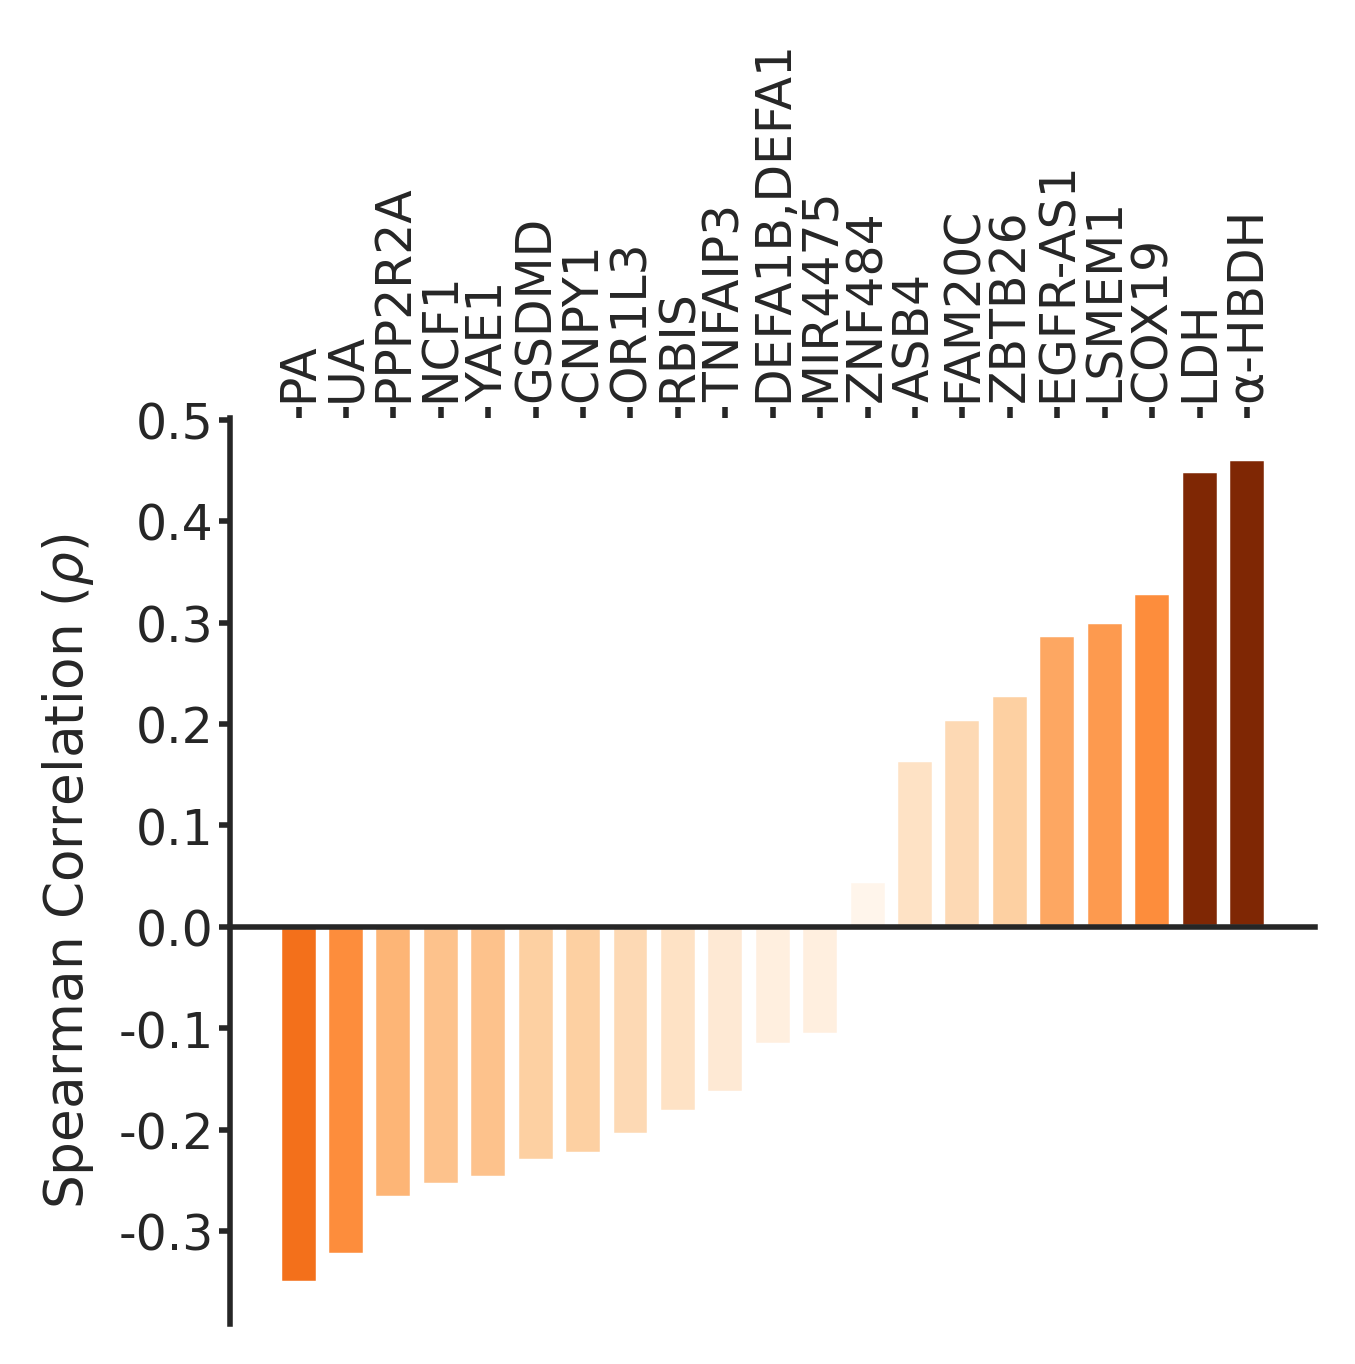

In [27]:
from matplotlib import cm

fig, ax = plt.subplots(1,1, figsize=(3.5,3))

x_pos = np.arange(spearm_corr.shape[0])
barWidth = 0.8

a = cm.get_cmap('Oranges',len(x_pos))
neg_log10p = spearm_corr['neg_log10p'].values
neg_log10p = (neg_log10p-neg_log10p.min())/(neg_log10p.max()-neg_log10p.min())

colors = a(neg_log10p)
    
ax.bar(x_pos, spearm_corr['rho'].values, width = barWidth,color=colors)
plt.xticks(x_pos, spearm_corr['feat_name'],rotation=90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.set_xlabel(None)
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(spearm_corr['feat_name'].values.tolist(),rotation=90)
ax.set_ylabel(r'Spearman Correlation ($\rho$)')
ax.tick_params(direction='out', length=2, pad=1)

plt.savefig("results_plt/risk_stratification_spearman_corr_1.pdf", dpi=400, bbox_inches='tight', format='pdf')

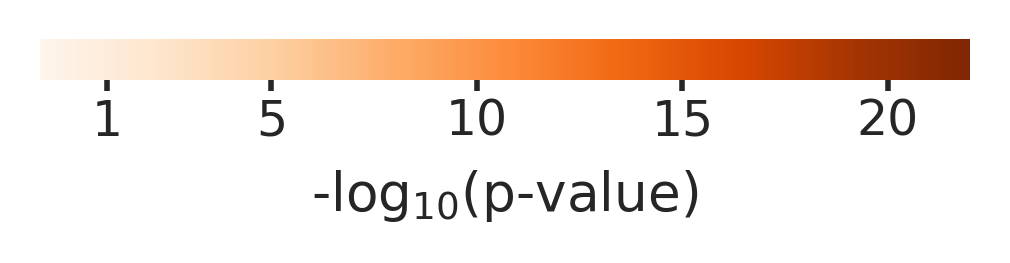

In [234]:
fig, ax = plt.subplots(1,1,figsize=(3, 1))
cmap = cm.get_cmap(cm.get_cmap('Oranges'))
colors = cmap(np.linspace(0, 1, cmap.N))
ax.imshow([colors],extent=[-0.63, 22, 0, 1])
ax.set_xticks([1,5,10,15,20])
ax.set_yticks([])
# ax.set_title(cmap_name)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel(r'-$\log_{10}$(p-value)')
ax.tick_params(direction='out', length=2, pad=1)
plt.savefig("results_plt/risk_stratification_spearman_corr_cbar.pdf", dpi=400, bbox_inches='tight')

## Heatmap

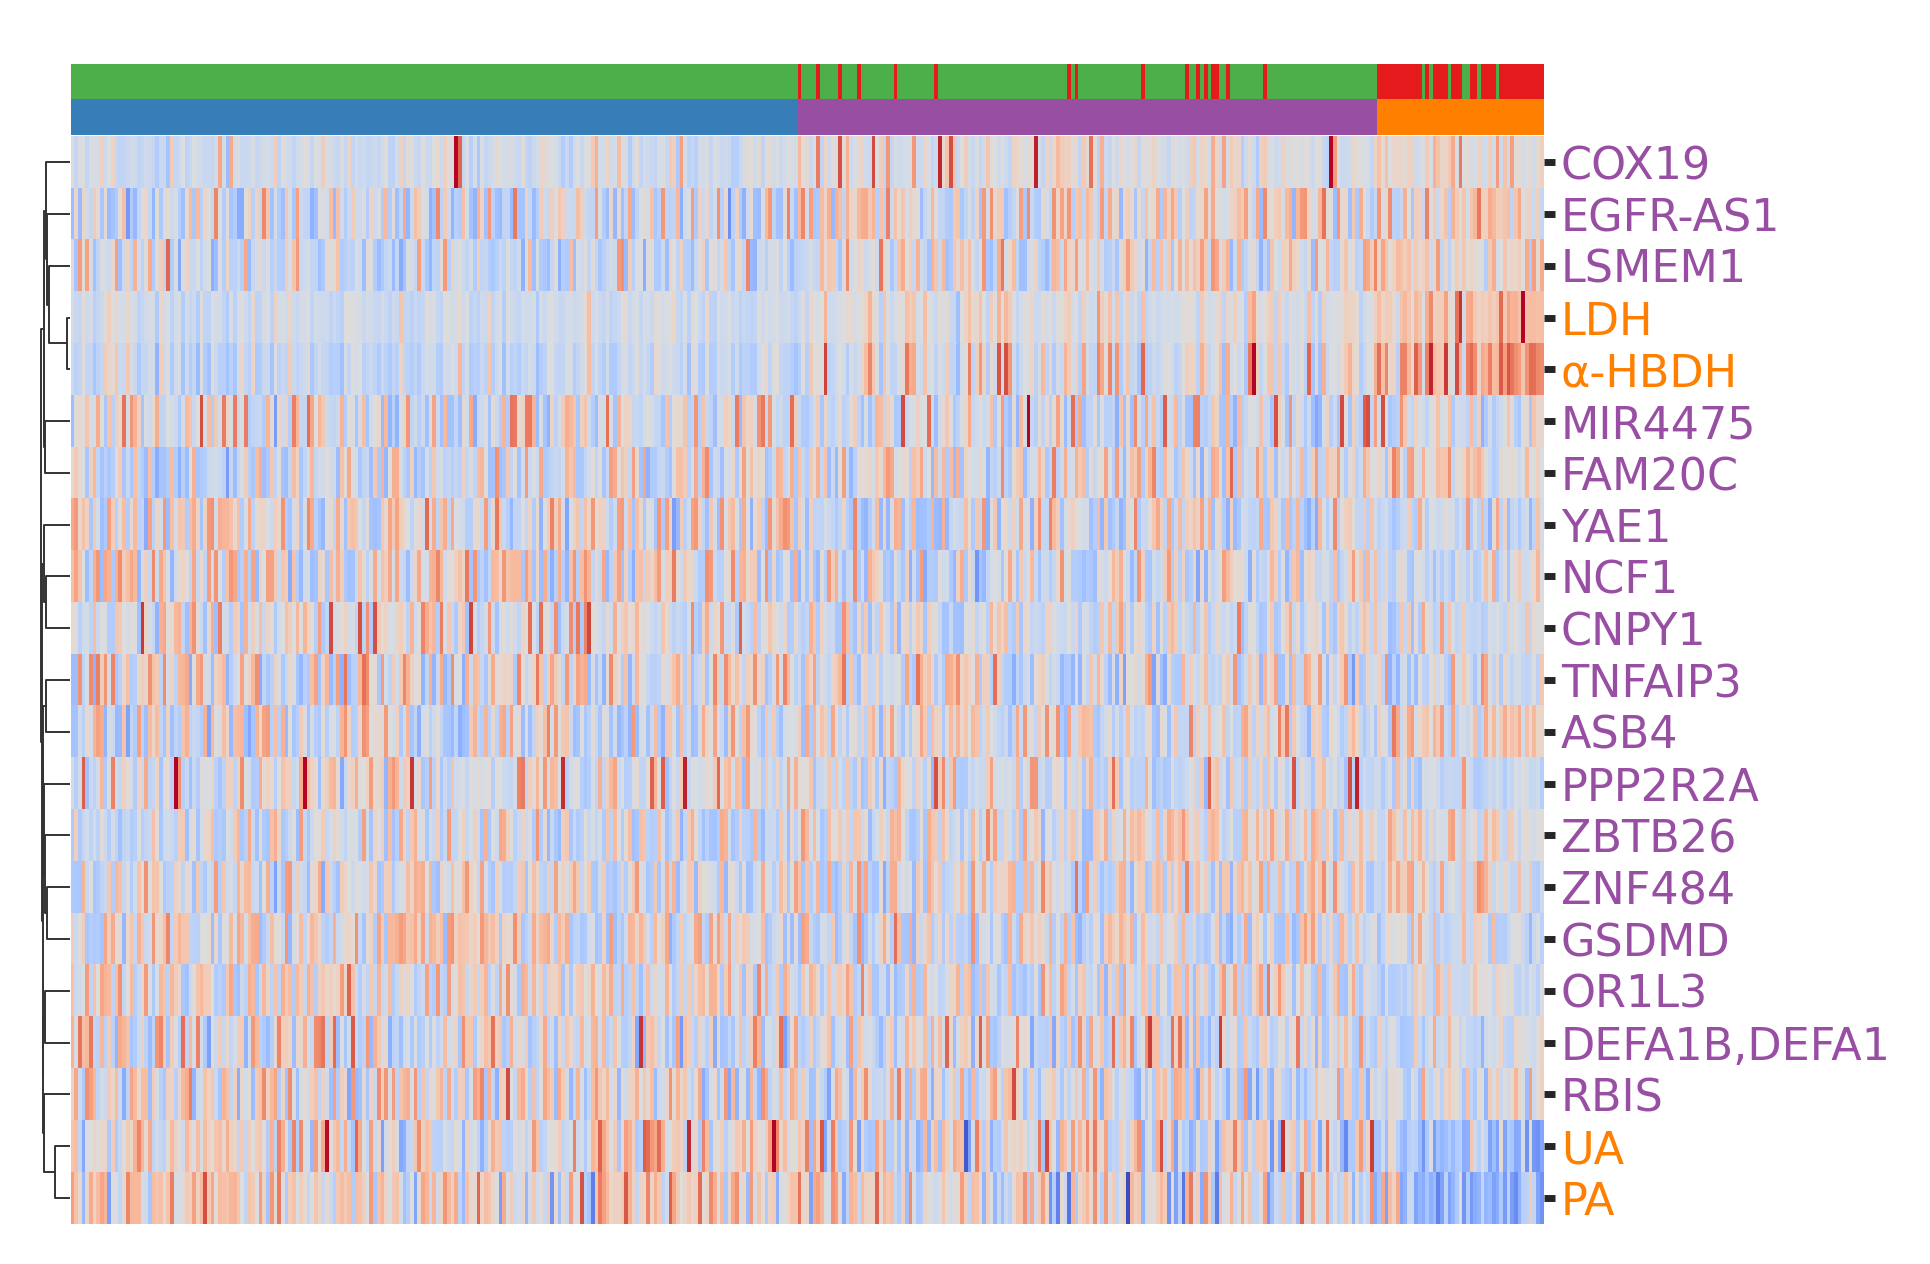

In [57]:
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from matplotlib import cm

lab_tss_imp_feats_data = pd.read_csv('results_plt/lab_tss_importance_feats_data_with_risk.csv', sep='\t')
lab_tss_imp_feats_data.rename(columns={"Uric_acid": "UA"}, inplace=True)

# featsss = [r'$\it{}$'.format(x) if feat_types[x] == 'tss' else x for x in lab_tss_imp_feats_data.columns[2:-1]]  

feat_types = dict(zip(lab_tss_imp_feats_data.columns[2:-1],['lab']*4 +['tss']*17))

lab_tss_imp_feats_data.sort_values(by='risk_level',inplace=True)
lab_tss_imp_feats_data.reset_index(drop=True, inplace=True)
pat_info = lab_tss_imp_feats_data[['ind', 'new_triage', 'risk_level']].copy()
feats_val_df = lab_tss_imp_feats_data.drop(columns=['ind', 'new_triage', 'risk_level']).copy()

feat_val_mat = feats_val_df.values
std_feat = feat_val_mat.std(0)

stnd_f = StandardScaler().fit_transform(feat_val_mat)
stand_feat = np.zeros_like(stnd_f)
lower_n = 5
min_feat = -lower_n*std_feat
max_feat = lower_n*std_feat

for k_f in range(len(std_feat)):
    stand_feat[:,k_f] = np.clip(stnd_f[:,k_f], min_feat[k_f], max_feat[k_f])
    
stand_feat_df = pd.DataFrame(data=stand_feat, columns=feats_val_df.columns)

flatui_2cls = {'Critical':'#e41a1c','Noncritical':'#4daf4a'}
flatui_3risk= {'Low Risk':'#377eb8','Medium Risk':'#984ea3','High Risk':'#ff7f00'}

col1 = pat_info['new_triage'].map({0:'Noncritical',1:'Critical'}).map(flatui_2cls)
col2 = pat_info['risk_level'].map({1:'Low Risk',2:'Medium Risk', 3:'High Risk'}).map(flatui_3risk)

g = sns.clustermap(stand_feat_df.T,col_colors=[col1,col2],cmap=plt.get_cmap("coolwarm"), 
                   z_score=1,dendrogram_ratio=0.02,
                   center=0.0,row_cluster=True, col_cluster=False, 
                   figsize=(4, 3.2),
                   vmin = -3.5, vmax=3.5, 
                   tree_kws={'linewidths':0.35},
                   # metric="correlation", method='complete',
                   metric="correlation", method='average',
                   # cbar_pos=(1.15, 0.65, 0.03, 0.4),
                   
                   xticklabels=False, yticklabels=False) 
    
reordered_labels = feats_val_df.columns[g.dendrogram_row.reordered_ind].tolist()
use_labels = feats_val_df.columns
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
g.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels)

g.ax_cbar.set_visible(False)

xlbls = g.ax_heatmap.yaxis.get_majorticklabels()
for lbl in xlbls:
    if feat_types[lbl.get_text()] == 'lab':
        lbl.set_color('#ff7f00')
    else:
        lbl.set_color('#984ea3')
        # lbl.set_fontstyle('italic')
    # lbl.set_fontsize(8)

g.ax_heatmap.tick_params(direction='out', length=2, pad=1)

plt.savefig("results_plt/risk_stratification_heatmap.pdf", dpi=400, bbox_inches='tight',format='pdf')

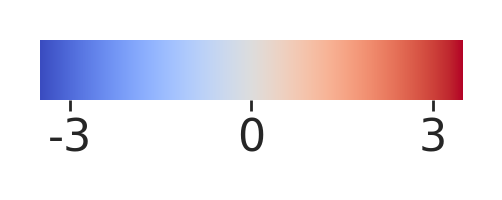

In [54]:
font_size = 8
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':400, 'axes.linewidth':0.5,
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size} # 'figure.figsize':(11.7/1.5,8.27/1.5)
sns.set(style='ticks',rc=rc) #talk, ticks, paper

fig, ax = plt.subplots(1, 1, figsize=(2, 0.2))
cmap = plt.cm.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, len(stand_feat_df.values.ravel())))
ax.imshow([colors],extent=[-3.5, 3.5, 0, 1])
ax.set_yticks([])
ax.set_xticks([-3,0,3])
ax.tick_params(axis='x', direction='out', length=2, pad=1, width=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.savefig("results_plt/risk_stratification_heatmap_cbar.pdf", format='pdf', dpi=400, bbox_inches='tight')


## Feature Distribution Amonge Three Risk Level   

## COX/KM analysis

In [7]:
clinical_rec = pd.read_csv(clinical_fname)[['ind','prog_outcome','LOS']] 
# prog_outcome, 1: recovery, 

lab_tss_imp_feats_data = pd.read_csv('results_plt/lab_tss_importance_feats_data_with_risk.csv', sep='\t')
lab_tss_imp_feats_data.rename(columns={"Uric_acid": "UA"}, inplace=True)

merge_prog = clinical_rec.merge(lab_tss_imp_feats_data, on='ind')

merge_prog['events']=merge_prog['prog_outcome'].map({1:1,2:0,3:0,4:0})
# merge_prog['events']=merge_prog['prog_outcome'].map({1:0,2:0,3:0,4:1})


median LOS High risk: 54.0
median LOS Medium risk: 41.0
median LOS Low risk: 37.0
v3v1logrank: <lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          31.23 <0.005     25.38
v3v2logrank: <lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          20.26 <0.005     17.17


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


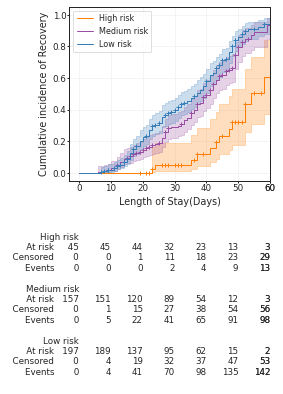

In [8]:
from lifelines import KaplanMeierFitter,NelsonAalenFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test

km_h = KaplanMeierFitter()
km_m = KaplanMeierFitter()
km_l = KaplanMeierFitter()

km_h.fit(merge_prog.loc[merge_prog['risk_level']==3,'LOS'], 
          event_observed=merge_prog.loc[merge_prog['risk_level']==3,'events'], label='High risk')

km_m.fit(merge_prog.loc[merge_prog['risk_level']==2,'LOS'], 
          event_observed=merge_prog.loc[merge_prog['risk_level']==2,'events'], label='Medium risk')

km_l.fit(merge_prog.loc[merge_prog['risk_level']==1,'LOS'], 
          event_observed=merge_prog.loc[merge_prog['risk_level']==1,'events'], label='Low risk')

fig, ax = plt.subplots(1,1, figsize=(3.6,3.2))

km_plt_param={'lw':1,
              'censor_styles':{'ms': 4},
              'show_censors':True,
              'ci_show':True,
              'ax':ax,
              # 'loc':slice(0.,60.)
             }

# print(km_l.cumulative_density_)

# km_h.plot_survival_function(color="#ff7f00", **km_plt_param)
# km_m.plot_survival_function(color="#984ea3", **km_plt_param)
# km_l.plot_survival_function(color="#377eb8", **km_plt_param)

km_h.plot_cumulative_density(color="#ff7f00", **km_plt_param)
km_m.plot_cumulative_density(color="#984ea3", **km_plt_param)
km_l.plot_cumulative_density(color="#377eb8", **km_plt_param)

ax.grid(True, color='0.95')

ax.set_xlim((-3, 60))
ax.set_xticks([0,10,20,30,40,50,60,60])

add_at_risk_counts(km_h,km_m,km_l,labels=['High risk','Medium risk','Low risk'], ax = ax)
svae_finame = 'results_plt/risk_stratification_kmplot.pdf'

ax.set_xlabel('Length of Stay(Days)')
ax.set_ylabel('Cumulative incidence of Recovery')
ax.legend(loc='best', fontsize=8)

ax.tick_params(direction='out', length=2, pad=1)

print('median LOS High risk: {}'.format(km_h.median_survival_time_))
print('median LOS Medium risk: {}'.format(km_m.median_survival_time_))
print('median LOS Low risk: {}'.format(km_l.median_survival_time_))



v3v1logrank = logrank_test(merge_prog.loc[merge_prog['risk_level']==3,'LOS'], 
                         merge_prog.loc[merge_prog['risk_level']==1,'LOS'],
                         event_observed_A=merge_prog.loc[merge_prog['risk_level']==3,'events'],
                         event_observed_B=merge_prog.loc[merge_prog['risk_level']==1,'events'])

v3v2logrank = logrank_test(merge_prog.loc[merge_prog['risk_level']==3,'LOS'], 
                         merge_prog.loc[merge_prog['risk_level']==2,'LOS'],
                         event_observed_A=merge_prog.loc[merge_prog['risk_level']==3,'events'],
                         event_observed_B=merge_prog.loc[merge_prog['risk_level']==2,'events'])

print('v3v1logrank: {}'.format(v3v1logrank))

print('v3v2logrank: {}'.format(v3v2logrank))

plt.savefig(svae_finame, dpi=400, bbox_inches='tight', format='pdf')




In [9]:
km_h.cumulative_density_at_times(60)

60    0.602769
Name: High risk, dtype: float64

In [10]:
km_m.cumulative_density_at_times(60)

60    0.934307
Name: Medium risk, dtype: float64

In [11]:
km_l.cumulative_density_at_times(60)

60    0.939625
Name: Low risk, dtype: float64

In [13]:
km_h.durations

array([23., 32., 21., 24., 69., 66., 37., 36., 52., 31., 39., 19., 26.,
       22., 27., 44., 30., 52., 41., 45., 52., 23., 21., 23., 60., 58.,
       50., 61., 52., 37., 48., 49., 39., 31., 47., 28., 57., 35., 43.,
       43., 30., 54., 48., 55., 51.])

In [16]:
np.median(km_h.durations),np.percentile(km_h.durations, [2.5, 97.5])

(41.0, array([21. , 65.5]))

In [42]:
print(km_h.confidence_interval_cumulative_density_)
print(km_m.confidence_interval_cumulative_density_)
print(km_l.confidence_interval_cumulative_density_)

      High risk_lower_0.95  High risk_upper_0.95
0.0               0.000000              0.000000
19.0              0.000000              0.000000
21.0              0.000000              0.000000
22.0              0.000000              0.000000
23.0              0.160798              0.003472
24.0              0.185826              0.012750
26.0              0.185826              0.012750
27.0              0.185826              0.012750
28.0              0.185826              0.012750
30.0              0.185826              0.012750
31.0              0.185826              0.012750
32.0              0.185826              0.012750
35.0              0.237978              0.027125
36.0              0.237978              0.027125
37.0              0.285370              0.044868
39.0              0.285370              0.044868
41.0              0.338628              0.066478
43.0              0.386690              0.090351
44.0              0.435186              0.116873
45.0              0.

In [45]:
hi_los = merge_prog.loc[merge_prog['risk_level']==3,'LOS'].values
me_los = merge_prog.loc[merge_prog['risk_level']==2,'LOS'].values
lo_los = merge_prog.loc[merge_prog['risk_level']==1,'LOS'].values

In [48]:
np.median(hi_los),np.percentile(hi_los, [2.5, 97.5])

(41.0, array([21. , 65.5]))

In [49]:
np.median(me_los),np.percentile(me_los, [2.5, 97.5])

(35.0, array([ 9.9, 59. ]))

In [50]:
np.median(lo_los),np.percentile(lo_los, [2.5, 97.5])

(29.0, array([ 8.9, 56.2]))

## Forest plot

### Univariate Cox

In [73]:
from lifelines import CoxPHFitter

In [99]:
clinical_rec = pd.read_csv(clinical_fname)[['ind','prog_outcome','LOS']] 
lab_tss_imp_feats_data = pd.read_csv('results_plt/lab_tss_importance_feats_data_with_risk.csv', sep='\t')
lab_tss_imp_feats_data.rename(columns={"Uric_acid": "UA"}, inplace=True)
merge_prog = clinical_rec.merge(lab_tss_imp_feats_data, on='ind')
merge_prog['events']=merge_prog['prog_outcome'].map({1:1,2:0,3:0,4:0})

merge_prog.to_csv('results_plt/lab_tss_importance_feats_data_with_risk_los.csv', sep='\t', index=False)

feats_name_ls = lab_tss_imp_feats_data.columns[2:-1].tolist()

In [148]:
univar_cph = None
for ii, f_name in enumerate(feats_name_ls):
    cph = CoxPHFitter()
    cph.fit(merge_prog[[f_name]+['LOS']+['events']], duration_col='LOS', event_col='events',robust=True)
    if ii == 0:
        univar_cph = cph.summary
    else:
        univar_cph = pd.concat([univar_cph, cph.summary], axis=0)

In [149]:
univar_cph

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
LDH,-0.007174,0.992852,0.001812,-0.010726,-0.003622,0.989332,0.996384,-3.958983,0.000075,13.697573
UA,0.003135,1.003140,0.000647,0.001867,0.004404,1.001868,1.004414,4.843966,0.000001,19.583649
α-HBDH,-0.008526,0.991510,0.002163,-0.012766,-0.004287,0.987315,0.995722,-3.941674,0.000081,13.593232
PA,0.002864,1.002868,0.000751,0.001392,0.004336,1.001393,1.004346,3.812502,0.000138,12.827579
PPP2R2A,0.057311,1.058985,0.032513,-0.006413,0.121035,0.993607,1.128665,1.762718,0.077948,3.681344
ZBTB26,0.340163,1.405177,0.382647,-0.409812,1.090139,0.663775,2.974686,0.888974,0.374017,1.418823
NCF1,0.545482,1.725440,0.246666,0.062025,1.028939,1.063989,2.798096,2.211418,0.027007,5.210527
CNPY1,0.075454,1.078374,0.108178,-0.136570,0.287478,0.872345,1.333062,0.697503,0.485488,1.042492
EGFR-AS1,-0.597544,0.550161,0.280397,-1.147111,-0.047976,0.317553,0.953157,-2.131065,0.033084,4.917732


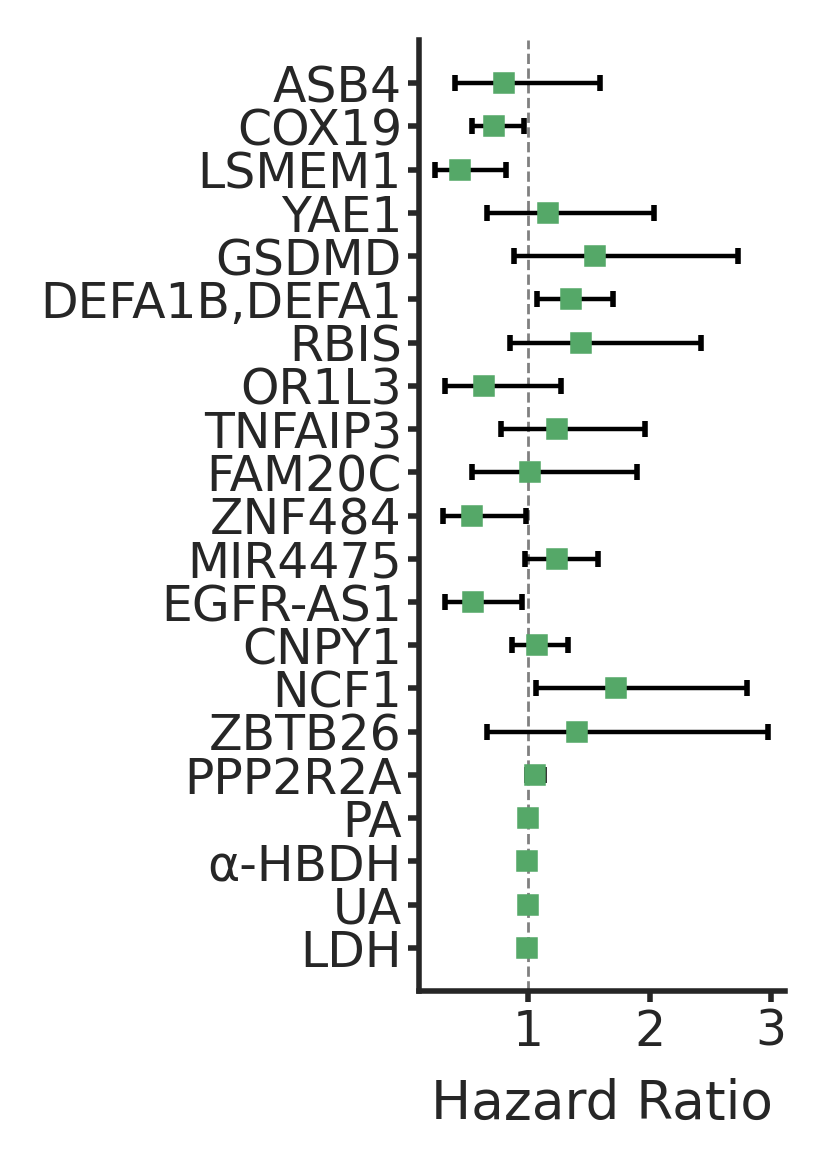

In [193]:
centimeter = 1/2.54  # centimeter in inches

fig, ax = plt.subplots(figsize=(3*centimeter, 8*centimeter))

x = univar_cph['exp(coef)'].values
y = np.arange(univar_cph.shape[0])

yticks_label=list(univar_cph.index)

ax.errorbar(x, y, xerr=[np.abs(x-univar_cph['exp(coef) lower 95%'].values),
                       np.abs(univar_cph['exp(coef) upper 95%'].values-x)], 
            fmt ='s',capsize=1.5,
            mfc='g',mec='g',
            # mew=0,
            color='black',markersize=3,elinewidth=0.8)

ax.axvline(1, color='gray', linewidth=0.5,ls='--',zorder=0)
ax.tick_params(direction='out', length=2, pad=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks(np.arange(univar_cph.shape[0]),yticks_label)
plt.xlabel('Hazard Ratio')

plt.savefig('results_plt/risk_stratification_hr.pdf', dpi=400, bbox_inches='tight', format='pdf')

### Multivariate Cox

In [194]:
tem_data = merge_prog[feats_name_ls+['LOS']+['events']]
cph = CoxPHFitter()
cph.fit(tem_data, duration_col='LOS', event_col='events')
cph.print_summary()
print(cph.hazard_ratios_)

<lifelines.CoxPHFitter: fitted with 399 total observations, 143 right-censored observations>
             duration col = 'LOS'
                event col = 'events'
      baseline estimation = breslow
   number of observations = 399
number of events observed = 256
   partial log-likelihood = -1251.78
         time fit was run = 2021-11-29 05:30:34 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
LDH           -0.01       0.99       0.00            -0.01             0.00                 0.99                 1.00
UA             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
α-HBDH         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
PA             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
PPP2R2A       -0.00       1.00       0.04            -0.09             0.08                 0.92                 1.08
ZBTB26         0.15       1.17       0.39            -0.60             0.91                 0.55                 2.49
NCF1           0.35       1.42       0.27            -0.18             0.88                 0.84                 2.42
CNPY1          0.02       1.02       0.08            -0.14             0.18                 0.87                 1.19
EGFR-AS1      -0.18       0.83       0.28            -0.74             0.37                 0.48                 1.45
MIR4475        0.35       1.42       0.14             0.08             0.62                 1.09                 1.85
ZNF484        -0.51       0.60       0.35            -1.19             0.18                 0.30                 1.19
FAM20C         0.37       1.45       0.31            -0.24             0.97                 0.79                 2.65
TNFAIP3       -0.01       0.99       0.26            -0.51             0.49                 0.60                 1.64
OR1L3         -0.85       0.43       0.39            -1.60            -0.09                 0.20                 0.91
RBIS          -0.11       0.90       0.27            -0.64             0.42                 0.53                 1.52
DEFA1B,DEFA1   0.24       1.27       0.14            -0.03             0.50                 0.97                 1.65
GSDMD          0.21       1.23       0.31            -0.40             0.82                 0.67                 2.27
YAE1           0.04       1.04       0.26            -0.47             0.56                 0.62                 1.74
LSMEM1        -0.74       0.48       0.31            -1.34            -0.14                 0.26                 0.87
COX19         -0.12       0.88       0.13            -0.39             0.14                 0.68                 1.15
ASB4          -0.11       0.90       0.31            -0.71             0.49                 0.49                 1.64

                 z      p   -log2(p)
covariate                           
LDH          -1.17   0.24       2.04
UA            3.25 <0.005       9.77
α-HBDH        0.12   0.91       0.14
PA            0.32   0.75       0.41
PPP2R2A      -0.07   0.94       0.08
ZBTB26        0.40   0.69       0.54
NCF1          1.30   0.19       2.38
CNPY1         0.21   0.84       0.26
EGFR-AS1     -0.65   0.52       0.95
MIR4475       2.56   0.01       6.60
ZNF484       -1.45   0.15       2.77
FAM20C        1.20   0.23       2.11
TNFAIP3      -0.03   0.98       0.03
OR1L3        -2.20   0.03       5.16
RBIS         -0.41   0.68       0.55
DEFA1B,DEFA1  1.74   0.08       3.62
GSDMD         0.68   0.50       1.00
YAE1          0.16   0.87       0.20
LSMEM1       -2.42   0.02       6.03
COX19        -0.92   0.36       1.48
ASB4         -0.35   0.73       0.46
---
Concordance = 0.67
Partial AIC = 2545.55
log-likelihood ratio test = 79.

covariate
LDH             0.994598
UA              1.002524
α-HBDH          1.000642
PA              1.000309
PPP2R2A         0.997003
ZBTB26          1.167107
NCF1            1.422361
CNPY1           1.016851
EGFR-AS1        0.832915
MIR4475         1.417691
ZNF484          0.602737
FAM20C          1.446461
TNFAIP3         0.993025
OR1L3           0.428578
RBIS            0.896060
DEFA1B,DEFA1    1.265554
GSDMD           1.234082
YAE1            1.043320
LSMEM1          0.477016
COX19           0.884466
ASB4            0.898231
Name: exp(coef), dtype: float64


<AxesSubplot:xlabel='log(HR) (95% CI)'>

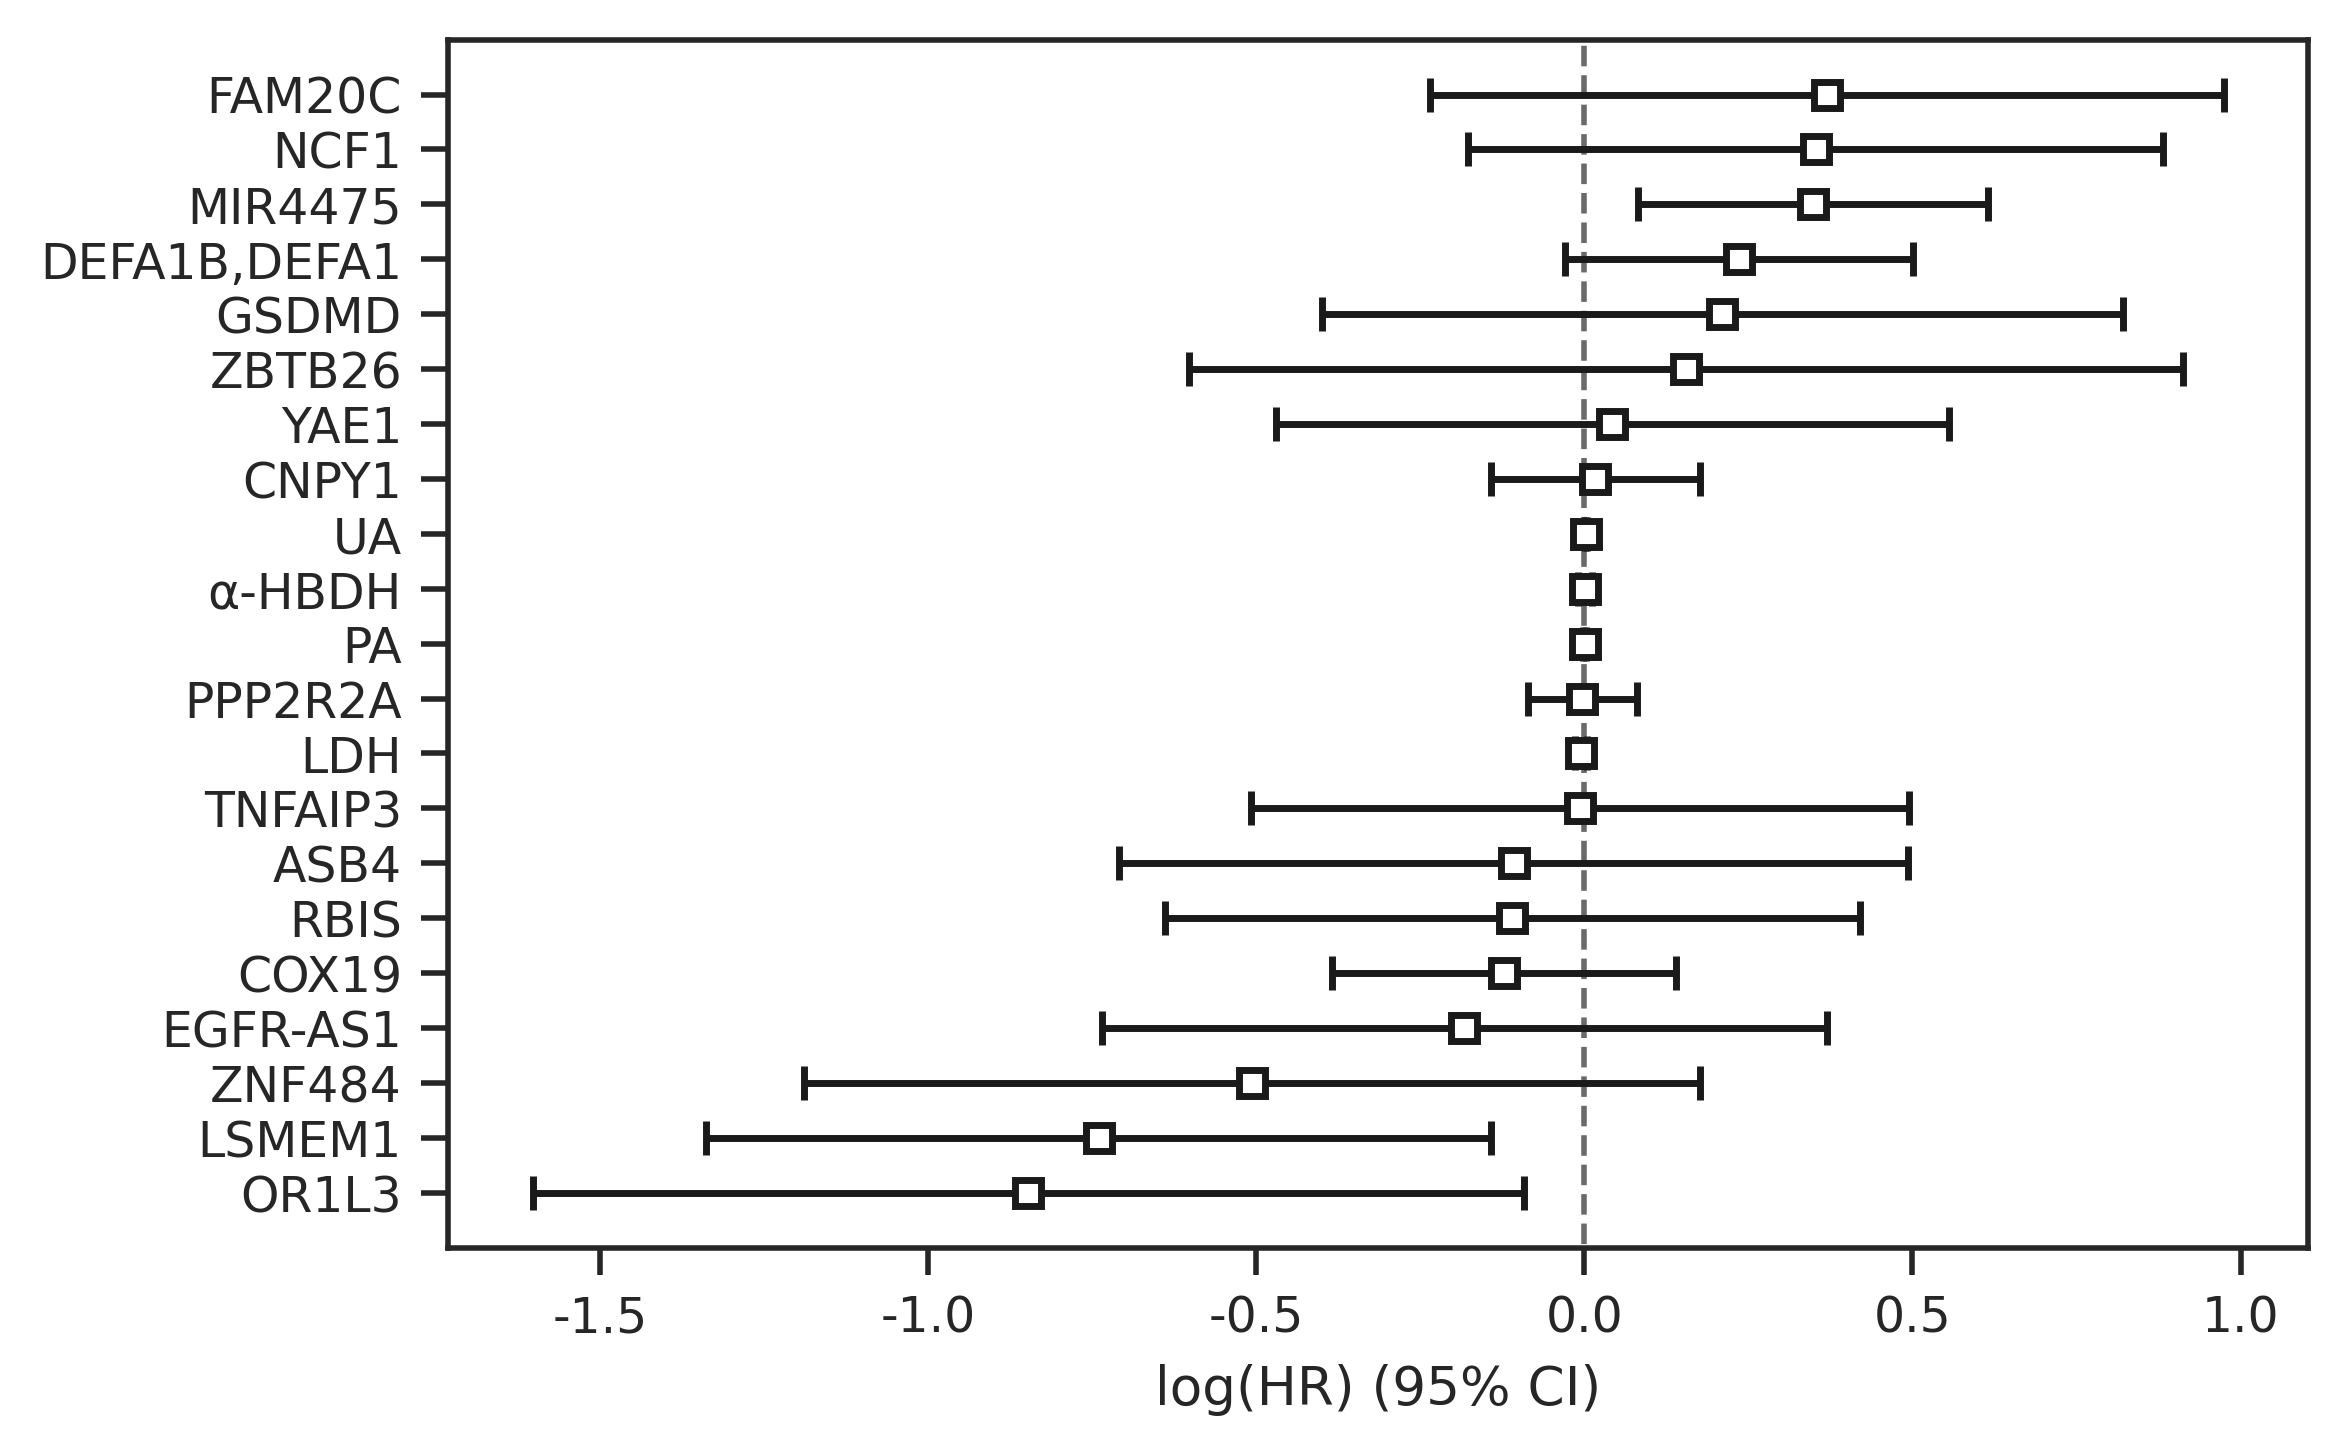

In [196]:
cph.plot()

In [13]:
pid='8354'

i_re_perf_fname = os.path.join(model_re_root_dir, 'm2model/34_fl_prefeature_performance.pkl')
with open(i_re_perf_fname, 'rb') as f:
    perf_feats = pickle.load(f)


/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})
